In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle
import numpy as np


#!conda install -n mldds -c anaconda joblib
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

import multiprocessing
num_cores = multiprocessing.cpu_count()

print("Cores: ", num_cores)

import time
import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': num_cores} )
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from MyTotoResearchv4 import *

%matplotlib inline
#Install nltk
#!conda install -c anaconda nltk
import nltk
#nltk.download ()

#https://pythonspot-9329.kxcdn.com/wp-content/uploads/2016/08/nltk-speech-codes.png
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import string

class TextAnalysis:
    def __init__(self, json_file):
        url = 'posts.json'
        self.df = pd.read_json(url, orient='columns')
        self.messages = self.df.message.fillna(' ')
    
    def preprocess (self):
        self.m = []
        self.noun = []
        self.adjective = []
        self.verb = []

        #Remove puncuations
        for m in self.messages:
            tokenizer = RegexpTokenizer(r'\w+')
            words = tokenizer.tokenize(m)

            stop_words = set(stopwords.words('english'))
            words = [w for w in words if not w in stop_words]

            msg = "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in words]).strip()

            self.m.append(msg)
            data = nltk.pos_tag(msg)
            noun = 0
            adjective = 0
            verb = 0 
            for word in data: 
                if 'NN' in word[1]: 
                    noun += 1
                else:
                    if 'JJ' in word[1]: 
                        adjective += 1
                    else:
                        if 'VB' in word[1]:
                            verb += 1
            self.noun.append(noun)
            self.adjective.append(adjective)
            self.verb.append(verb)
        df_features = pd.DataFrame()
        df_features['MsgSize'] = [len(i) for i in self.messages]
        df_features['engag'] = self.df.engagements #/df_features['MsgSize']
        df_features['Noun'] = self.noun #/df_features['MsgSize']
        df_features['Adj'] = self.adjective #/df_features['MsgSize']
        df_features['Verb'] = self.verb #/df_features['MsgSize']


        self.df_features = df_features
        self.df = []
        self.messages = []
#        print(self.m, ' ', self.noun, ' ', self.adjective, ' ', verb)



ta = TextAnalysis('posts.json')
ta.preprocess()
ta.df_features.head()
#ta.df.info()

Cores:  12


/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4900: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/uqapp/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))


Done.


/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/uqapp/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


,MsgSize,engag,Noun,Adj,Verb
0,383,740,202,30,41
1,279,308,131,10,27
2,259,362,144,13,21
3,310,53,172,12,21
4,270,346,136,8,23


In [2]:
df = ta.df_features[['engag','MsgSize','Noun','Adj','Verb']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 5 columns):
engag      708 non-null int64
MsgSize    708 non-null int64
Noun       708 non-null int64
Adj        708 non-null int64
Verb       708 non-null int64
dtypes: int64(5)
memory usage: 27.7 KB


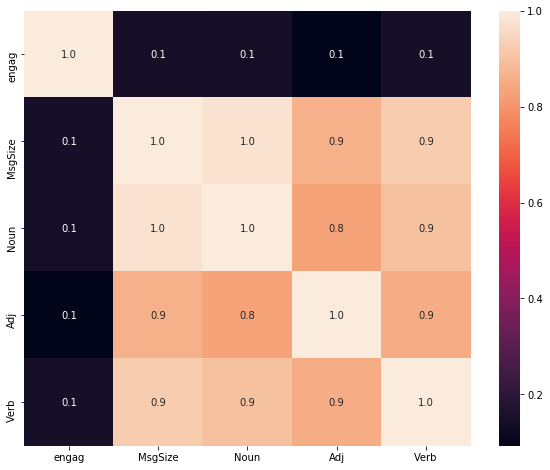

In [3]:
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), ax=axes, annot=True, fmt='.1f')

In [4]:
X = ta.df_features[['MsgSize','Noun','Adj','Verb']]
X.info()
y = ta.df_features[['engag']]
y.info()
y.shape[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 4 columns):
MsgSize    682 non-null int64
Noun       682 non-null int64
Adj        682 non-null int64
Verb       682 non-null int64
dtypes: int64(4)
memory usage: 21.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 1 columns):
engag    682 non-null int64
dtypes: int64(1)
memory usage: 5.4 KB


1

In [4]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

# Initialize the constructor
model = Sequential()

# Add an input layer 
model.add(Dense(512, activation='tanh', input_shape=(X.shape[1],)))

# Add one hidden layer 
model.add(Dense(8, activation='relu'))

# Add an output layer 
model.add(Dense(y.shape[1], activation='sigmoid'))

NameError: name 'X' is not defined

In [6]:
Dense??

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

model.fit(X_train, y_train,epochs=20, batch_size=5, verbose=1)

/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/Users/uqapp/anaconda3/envs/mldss/lib/python3.6/site-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


Epoch 1/20
456/456 [==============================] - 1s 3ms/step - loss: -615.9827 - acc: 0.0000e+00
Epoch 2/20
456/456 [==============================] - 0s 294us/step - loss: -3165.6107 - acc: 0.0000e+00
Epoch 3/20
456/456 [==============================] - 0s 296us/step - loss: -4463.7816 - acc: 0.0000e+00
Epoch 4/20
456/456 [==============================] - 0s 583us/step - loss: -5773.5784 - acc: 0.0000e+00
Epoch 5/20
456/456 [==============================] - 0s 340us/step - loss: -5871.3776 - acc: 0.0000e+00
Epoch 6/20
456/456 [==============================] - 0s 395us/step - loss: -5871.3775 - acc: 0.0000e+00
Epoch 7/20
456/456 [==============================] - 0s 339us/step - loss: -5871.3775 - acc: 0.0000e+00
Epoch 8/20
456/456 [==============================] - 0s 503us/step - loss: -5871.3775 - acc: 0.0000e+00
Epoch 9/20
456/456 [==============================] - 0s 540us/step - loss: -5871.3775 - acc: 0.0000e+00
Epoch 10/20
456/456 [==============================] - 0s 

In [8]:
y_pred = model.predict(X_test)

In [9]:
score = model.evaluate(X_test, y_test,verbose=1)

print(score)

226/226 [==============================] - 0s 809us/step
[-5843.448233545354, 0.0]
